In [183]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import os
from os.path import join as oj
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.linear_model import LinearRegression, LogisticRegression, RidgeCV
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_validate, train_test_split
from sklearn import metrics
import numpy as np
from collections import Counter
from sklearn.datasets import make_classification
from torch import nn
import torch.nn.functional as F
import torch
from copy import deepcopy
from sklearn import metrics
plt.style.use('dark_background')
import mat4py
import pandas as pd
import data_tracks
from skorch.callbacks import Checkpoint, TrainEndCheckpoint
from skorch import NeuralNetRegressor, NeuralNetClassifier
import models
from imblearn.over_sampling import RandomOverSampler
from statsmodels import robust
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVC, SVR
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.model_selection import KFold
import pickle as pkl
from tqdm import tqdm
from sklearn.metrics import r2_score
import train_reg
#df = data_tracks.get_tracks() # note: different Xs can be different shapes
#df = data_tracks.remove_invalid_tracks(df)
#df = data_tracks.preprocess(df)
#df = data_tracks.add_outcome(df)
#n = df.shape[0]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [185]:
df = data_tracks.get_data()
n = df.shape[0]
df.keys()

Index(['X', 'Y', 'X_pvals', 'Y_pvals', 'pixel', 'pixel_left', 'pixel_right',
       'pixel_up', 'pixel_down', 'catIdx', 'total_displacement',
       'mean_square_displacement', 'lifetime', 'x_pos', 'y_pos', 'center_max',
       'left_max', 'right_max', 'up_max', 'down_max', 'cell_num', 'X_max',
       'X_min', 'X_mean', 'X_std', 'Y_max', 'Y_mean', 'Y_std', 'rise', 'fall',
       'max_diff', 'min_diff', 'y_score', 'y_thresh', 'y', 'y_single_sig',
       'y_double_sig', 'y_consec_sig', 'sc_0', 'sc_1', 'sc_2', 'sc_3', 'sc_4',
       'sc_5', 'sc_6', 'sc_7', 'sc_8', 'sc_9', 'sc_10', 'sc_11', 'nmf_0',
       'nmf_1', 'nmf_2', 'nmf_3', 'nmf_4', 'nmf_5', 'nmf_6', 'nmf_7', 'nmf_8',
       'nmf_9', 'nmf_10', 'nmf_11', 'X_smooth_spl', 'X_smooth_spl_dx',
       'X_smooth_spl_d2x', 'X_max_spl', 'dx_max_spl', 'd2x_max_spl',
       'num_local_max_spl', 'num_local_min_spl'],
      dtype='object')

In [186]:
df = train_reg.add_robust_features(df)
df = train_reg.log_transforms(df)

In [191]:
outcome_def = 'Y_max_log'
out_dir = f'results/regression/{outcome_def}'
os.makedirs(out_dir, exist_ok=True)
feat_names_log = ['X_95_quantile_log', 'X_mad_log', 
              'total_displacement','mean_square_displacement', 'lifetime', 'patch_diff_log',
              'rise_log', 'fall_log']
for model_type in tqdm(['linear', 'gb', 'rf', 'svm', 'mlp2', 'dt']):
    out_name = f'{model_type}'
                    #print(out_name)
    train_reg.train_reg(df, feat_names=feat_names_log, model_type=model_type, 
                 outcome_def=outcome_def,
                 out_name=f'{out_dir}/{out_name}.pkl')    


  0%|          | 0/6 [00:00<?, ?it/s]

[0.20834200581537343, 0.1544746943807087, 0.0696540405799243, -0.3594920341638672, 0.037808921624589265]


 33%|███▎      | 2/6 [00:00<00:01,  3.83it/s]

[0.19789501646707452, 0.12489468441199314, 0.11433120657325901, -0.29928002817532495, 0.10430485928361344]


 50%|█████     | 3/6 [00:03<00:03,  1.12s/it]

[0.19089055369339025, 0.12032043161721129, 0.08763895343906036, -0.2894877735519463, 0.09184674661597392]


 67%|██████▋   | 4/6 [00:04<00:01,  1.08it/s]

[0.0906610418302789, -0.010142837732474153, -0.07435899792979117, -0.4704866040267408, 0.10245076413966103]


100%|██████████| 6/6 [00:06<00:00,  1.12s/it]

[0.18425277415702024, 0.13836037983279714, 0.05008616190082471, -0.2093615016971324, -0.2875450124526737]
[-1.215425782370617, -1.005790014544524, -1.645244324557801, -0.5757815526124703, -1.2071554286954589]


In [192]:
results = load_results(out_dir)
r = results
r = r[[k for k in r if not 'std' in k]]
r = r[[k for k in r if not '_f' in k]]
# r = r[r.index.str.contains('ros')] # only use random sampling
r = r.sort_values(by=['r2'], ascending=False)
# r.style.background_gradient(cmap='viridis', axis=None) # all values on same cmap
r.style.background_gradient(cmap='viridis', axis=0) # columns differently colored
# r.style.apply(viz.highlight_max, subset=[k for k in r if not 'std' in k])

,cv_accuracy_by_cell,r2
model_type,,
gb,"[0.19789501646707452, 0.12489468441199314, 0.11433120657325901, -0.29928002817532495, 0.10430485928361344]",0.027
rf,"[0.19089055369339025, 0.12032043161721129, 0.08763895343906036, -0.2894877735519463, 0.09184674661597392]",0.021
linear,"[0.20834200581537343, 0.1544746943807087, 0.0696540405799243, -0.3594920341638672, 0.037808921624589265]",0
mlp2,"[0.18425277415702024, 0.13836037983279714, 0.05008616190082471, -0.2093615016971324, -0.2875450124526737]",-0.04
svm,"[0.0906610418302789, -0.010142837732474153, -0.07435899792979117, -0.4704866040267408, 0.10245076413966103]",-0.091
dt,"[-1.215425782370617, -1.005790014544524, -1.645244324557801, -0.5757815526124703, -1.2071554286954589]",-1.072


Text(0, 0.5, 'r2')

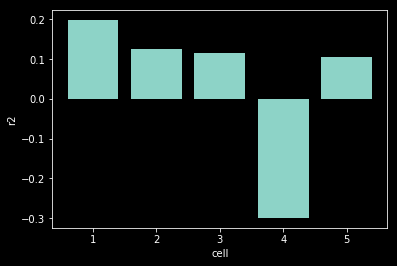

In [189]:
plt.bar(range(1, 6), r['cv_accuracy_by_cell'][0])
plt.xlabel('cell')
plt.ylabel('r2')

In [118]:
x_argmax = np.array([np.argmax(df.iloc[i].X) for i in range(len(df))])
ymax_after_cla_peak = np.array([np.max(df.iloc[i].Y[x_argmax[i]:]) for i in range(len(df))])
df['y_after_cla_peak'] = ymax_after_cla_peak
df['y_after_cla_peak_log'] = np.log(ymax_after_cla_peak - min(ymax_after_cla_peak) + 1)

-223.07639804291784


[260 258 183 325 267]


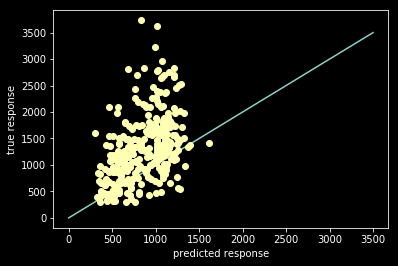

In [195]:
fname = 'gb.pkl'
d = pkl.load(open(oj(out_dir, fname), 'rb'))
print(d['num_pts_by_fold_cv'])
plt.plot(range(3500), range(3500))
plt.plot(np.exp(d['y_preds'][4]), np.exp(df.iloc[np.where(df['cell_num'] == 4)]['Y_max_log']), 'o')
plt.xlabel('predicted response')
plt.ylabel('true response')
plt.show()

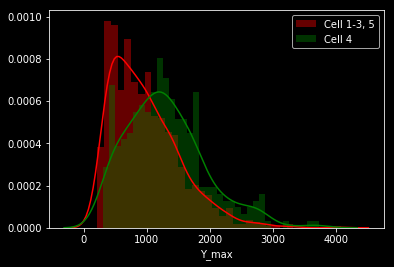

In [196]:
df_val = df.iloc[np.where(df['cell_num'] == 4)]
df_train = df[df.cell_num.isin([1, 2, 3, 5])]
sns.distplot(df_train['Y_max'], hist=True, kde=True, 
             bins=int(180/5), color='red', label='Cell 1-3, 5')
sns.distplot(df_val['Y_max'], hist=True, kde=True, 
             bins=int(180/5), color='green', label='Cell 4')
plt.legend()

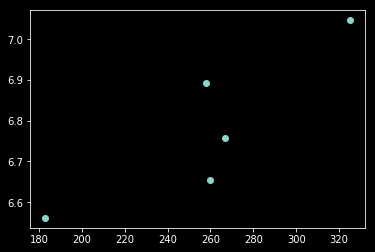

In [197]:
n_tracks = d['num_pts_by_fold_cv']
y_max_median = [np.mean(df.iloc[np.where(df['cell_num'] == i)]['Y_max_log']) for i in range(1, 6)]
plt.plot(n_tracks, y_max_median, 'o')

# basic eda

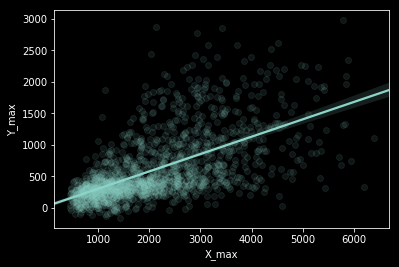

In [18]:
sns.regplot('X_max', 'Y_max', df, scatter_kws={'alpha': 0.1})

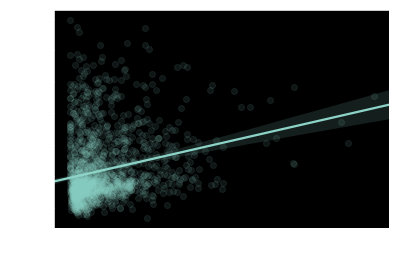

In [3]:
sns.regplot('totalDisplacement', 'Y_max', df, scatter_kws={'alpha': 0.1})

In [34]:
m = RidgeCV(store_cv_values=True)
m.fit(df['X_max'].values.reshape(-1, 1), df['Y_max'].values.reshape(-1, 1), )

RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=None, fit_intercept=True,
        gcv_mode=None, normalize=False, scoring=None, store_cv_values=True)

In [37]:
m.cv_values_[0]

array([[9359.74290596, 9359.74286412, 9359.74244571]])

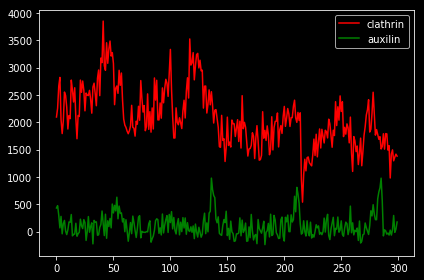

In [91]:
# 0 is the first channel (clathrin)
R, C = 1, 1
# R, C = 5, 5
for i in range(R * C):
    plt.subplot(R, C, i + 1)
    row = df.iloc[i]
    plt.plot(row.X, color='red', label='clathrin')
    plt.plot(row.Y, color='green', label='auxilin')
#     plt.axi('off')
plt.legend()

plt.tight_layout()
plt.show()

# fit maxconv

In [2]:
# pad lists with zeros
X_mat = data_tracks.extract_X_mat(df)
Y_max = df['Y_max'].values.astype(np.float32)
Y_max -= np.min(Y_max)
Y_max /= np.std(Y_max) # zero min, stddev 1
# X_feat, Y_max = data.extract_single_pixel_features(X, Y)
# Y_max -= np.min(Y_max) # make all vals positive
# print('shapes', X_feat.shape, Y_max.shape)

# m.fit(X_feat, Y_max)
X_train, X_test, Y_train, Y_test = train_test_split(X_mat, Y_max, test_size=0.33, random_state=42)
# results = cross_validate(m, X_feat, y_max, cv=2, return_train_score=True, return_estimator=True)

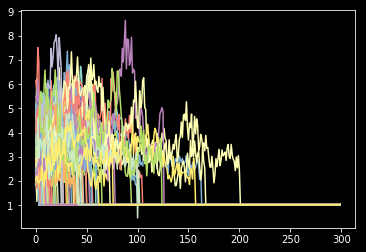

In [15]:
for i in range(100):
    plt.plot(X_train[i])

In [16]:
conv_size = 10
num_channels = 1
dirname = oj('out', f'conv_size={conv_size}_num_channels={num_channels}')
# dirname = 'conv_size=8_num_chanels=30' # conv_size x num_conv
# train_end_cp = TrainEndCheckpoint(dirname='exp1')
# net = NeuralNetClassifier(
#     MyModule, lr=0.5, callbacks=[cp, train_end_cp]
# )

net = NeuralNetRegressor(
    models.MaxConv(num_units=num_channels, kernel_size=conv_size, use_bias=False),
    max_epochs=1000,
    batch_size=1000,
    lr=1e-3,
    iterator_train__shuffle=True,
    optimizer=torch.optim.SGD,
    callbacks=[Checkpoint(dirname=dirname)],
    device='cpu'
)

In [ ]:
# train
net.fit(X_train, Y_train.reshape(-1, 1))
# pkl.dump(net, open( "net_big.pkl", "wb" ))

Re-initializing optimizer.
(10,)
offset 0.15514989


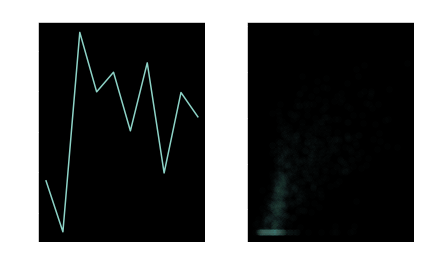

In [31]:
# load trained model and plot
net.initialize() # This is important!
net.load_params(
    f_params=oj(dirname, 'params.pt'), f_optimizer=oj(dirname, 'optimizer.pt'), f_history=oj(dirname, 'history.json')
)


R, C = 1, 2

ws = net.module_.state_dict()['conv1.weight'].cpu().numpy().squeeze()
print(ws.shape)
print('offset', net.module_.state_dict()['offset'].cpu().numpy().squeeze())

plt.subplot(R, C, 1)
plt.title('filters')
plt.plot(ws.T)

plt.subplot(R, C, 2)
preds = net.predict(X_train)
plt.plot(Y_train, preds, 'o', alpha=0.01)
plt.title(f'mse {np.mean(np.square(Y_train - preds)):0.2f} r2 {metrics.r2_score(Y_train, preds):0.2f}')
plt.xlabel('Y')
plt.ylabel('pred')

plt.tight_layout()
plt.savefig(dirname + '.png')
plt.show()